# Quantitative Analysis Assignment

## Goal

For the two time series provided, first clean the data and analyze it, focusing on the following questions:
1. Can time series 1 data be used to forecast its own future?
2. Can time series 2 data be used to forecast its own future?
3. Can time series 2 data be used to forecast the future of time series 1 or vice versa?

No context is provided for the time series, therefore the answers must be derived purely from the data.

## Import packages and include plotting preamble

In [69]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pywt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_predict

In [70]:
%matplotlib inline

In [71]:
# Define defaults to make the plots pretty and readable
plt.style.use('bmh')
mpl.rcParams['figure.figsize'] = (16,8)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'black'
mpl.rcParams['axes.labelsize'] = 20

# Data exploration/cleaning

In [72]:
# Read in the provided CSV file as a NumPy array
data = np.genfromtxt('quantTest_data.csv', delimiter=',')

# Check the dimensions of the data to verify that it should be organized according to
# time, series1, series2.
data.shape

(1315441, 3)

In [73]:
# Print the first 20 rows of the data to better see its structure.
for i in range(20):
    print(data[i,:])

[733408.000521           nan           nan]
[7.33408002e+05            nan 8.75050000e-01]
[733408.003299           nan           nan]
[733408.004687           nan           nan]
[733408.006076           nan           nan]
[733408.007465           nan           nan]
[733408.008854           nan           nan]
[733408.010243           nan           nan]
[733408.011632           nan           nan]
[733408.013021           nan           nan]
[733408.01441          nan          nan]
[733408.015799           nan           nan]
[733408.017188           nan           nan]
[733408.018576           nan           nan]
[733408.019965           nan           nan]
[733408.021354           nan           nan]
[733408.022743           nan           nan]
[733408.024132           nan           nan]
[733408.025521           nan           nan]
[733408.02691          nan          nan]


We make two preliminary comments: First, the time is not in the usual datetime format, rather in MATLAB's own format, which is described thus:
> A serial date number represents a calendar date as the number of days that has passed since a fixed base date. In MATLAB, the serial date number 1 is January 1, 0000.
>
> MATLAB also uses serial time to represent fractions of days beginning at midnight; for example, 6 p.m. equals 0.75 serial days. So the string '31-Oct-2003, 6:00 PM' in MATLAB is date number 731885.75.

Some research and experimentation has found that, for Python, the most elegant and accurate way to convert MATLAB format times to standard time stamps is by means of the method `to_datetime` from the Pandas package, rather than the native datetime package. _However_, this particular package calculates times from the Unix epoch start, occurring on the midnight of 1970-01-01 so that all MATLAB times must have the days corresponding to the time period 0 AD to 1970 AD initially subtracted from it. 

The number of days must be calculated using the convention that MATLAB has used, despite the complicated history surrounding leap years in the modern calendar (Fun fact: Did you know that 4 AD was not a leap year? Curiously, the UNIX command `cal` incorrectly lists this year as a leap year. For more information, see Vardi, I. "The Julian Calendar." §3.5.1 in Computational Recreations in Mathematica. Redwood City, CA: Addison-Wesley, p. 239, 1991.). To do so, we use the MATLAB code

`datenum('1970-01-01')`

which returns **719529**, therefore suggesting that this is the constant we need to subtract from the times before employing `to_datetime`. We do this below:

In [74]:
# Convert the MATLAB format timestamps to 'real' timestamps.
# Note that unit = 'D' specifies that the input is in days.
realtimes = pd.to_datetime(data[:,0]-719529, unit='D')
realtimes

DatetimeIndex(['2008-01-01 00:00:45.014400768',
               '2008-01-01 00:02:45.023999232',
               '2008-01-01 00:04:45.033597696',
               '2008-01-01 00:06:44.956795648',
               '2008-01-01 00:08:44.966404096',
               '2008-01-01 00:10:44.976002816',
               '2008-01-01 00:12:44.985601280',
               '2008-01-01 00:14:44.995199744',
               '2008-01-01 00:16:45.004798208',
               '2008-01-01 00:18:45.014396672',
               ...
               '2012-12-31 23:42:45.014404864',
               '2012-12-31 23:44:45.024003328',
               '2012-12-31 23:46:45.033601792',
               '2012-12-31 23:48:45.043200256',
               '2012-12-31 23:50:44.966398208',
               '2012-12-31 23:52:44.975996672',
               '2012-12-31 23:54:44.985595136',
               '2012-12-31 23:56:44.995203840',
               '2012-12-31 23:58:45.004802304',
               '2013-01-01 00:00:45.014400768'],
              dtype=

The second preliminary comment is that there are _a lot_ of `nan` entries in the data. Before we decide on what to do with these entries, let us first quantify the number of NaNs in both time series and where in the series these occur. The time differences between sequential non-NaN points must also be considered to consider whether the time series are evenly spaced in time.

In [75]:
# Count the number of NaNs that occur in both time series
print(f'Number of NaNs in time series 1: {np.isnan(data[:,1]).sum()}')
print(f'% of total number of data points in series 1: {100*np.isnan(data[:,1]).sum()/data.shape[0]} % \n')
print(f'Number of NaNs in time series 2: {np.isnan(data[:,2]).sum()}')
print(f'% of total number of data points in series 2: {100*np.isnan(data[:,2]).sum()/data.shape[0]} %')

Number of NaNs in time series 1: 1113924
% of total number of data points in series 1: 84.68065082356411 % 

Number of NaNs in time series 2: 378953
% of total number of data points in series 2: 28.808057525955174 %


In [76]:
# Set aside the indices corresponding to non-Nan in time series 1 and 2 respectively.
indices_1 = np.argwhere(~np.isnan(data[:,1])).flatten() # Note ~np.isnan returns the opposite of np.isnan
indices_2 = np.argwhere(~np.isnan(data[:,2])).flatten()

# Define the first-order differences in the non-NaN times for series 1 and 2;
# that is to say, for an array of N entries [x0, x1, x2,..., x(N-1)], produce an
# array of N-1 entries with [x1-x0, x2-x1,..., x(N-1)-x(N-2)]
time_diff_1 = np.diff(realtimes[indices_1], n=1)*10**-9/60/60 # Note that np.diff produces time differences in nanoseconds, so this output will be in hours
time_diff_2 = np.diff(realtimes[indices_2], n=1)*10**-9/60/60

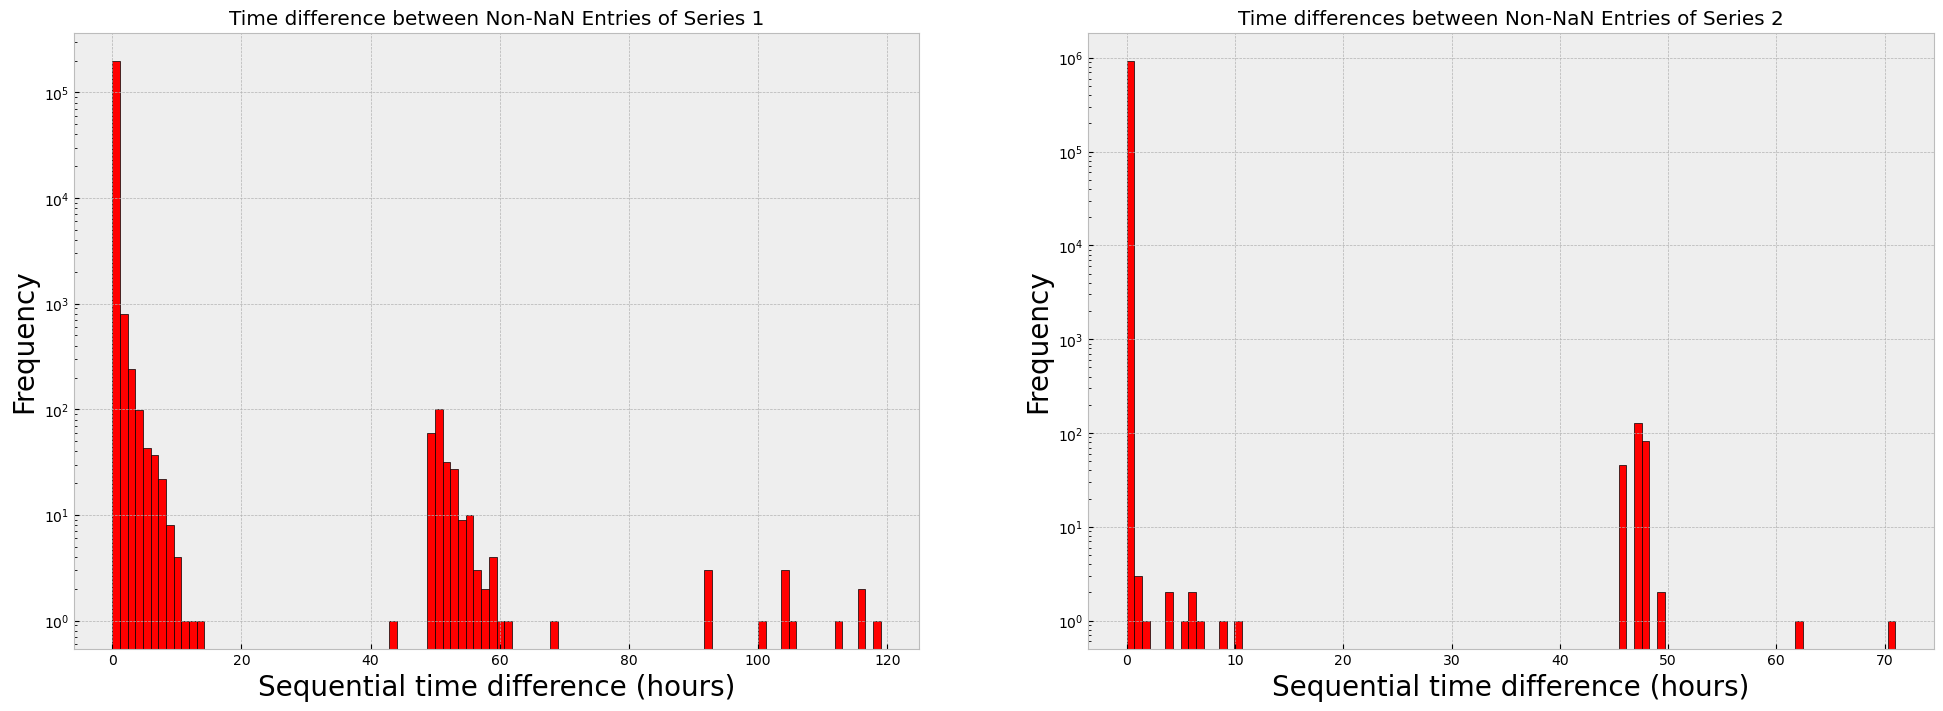

In [77]:
# Plot a histogram of the time differences of the two series
fig, ax = plt.subplots(ncols=2, figsize=(24,8))

# Plot the information of the first time series
ax[0].hist(time_diff_1.astype(float), bins=100, color='red', edgecolor='black') # The object type of the array needs to be converted to a float in order to be plotted.
ax[0].set_xlabel('Sequential time difference (hours)')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Time difference between Non-NaN Entries of Series 1')
ax[0].set_yscale('log') # Log scale to better help visualize the heights of the respective peaks

# Plot the information of the second time series
ax[1].hist(time_diff_2.astype(float), bins=100, color='red', edgecolor='black')
ax[1].set_xlabel('Sequential time difference (hours)')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Time differences between Non-NaN Entries of Series 2')
ax[1].set_yscale('log');

We comment on our results: First, we note that there is about 4 times more points in time series 1 with NaN entries than time series 2, covering almost 85% of the total data series. Despite this large percentage however, the figure above shows that the differences between non-NaN entries is relatively regular over the 5 year period that the data spans, with the largest difference being 119 hours or about 5 days in time series 1 and 71 hours or approximately 3 days. The most frequent time difference for both series is within a couple of minutes, with the highest frequency peak of series 1 having a larger width than its series 2, due to the former's significant data loss over the latter.

With a mind to employ autocorrelation and other measures (though, there are techniques, such as the Lomb-Scargle periodogram, which can compute these measures from non-uniformly spaced data), **we resample our data such that it is weekly**. If this approach is inadequate, the data can be revisited and possibly interpolated if the driving phenomenon is at a higher time resolution. 

In [78]:
# For terseness, create new arrays which store the non-NaN data from each time series 
# and two separate arrays which store the timestamps for when these occur.
series_1 = data[indices_1,1]
times_1 = realtimes[indices_1]
series_2 = data[indices_2,2]
times_2 = realtimes[indices_2]

# For each series, create a dummy Pandas series, utilzing its resample method to 
# massage the time differences in the data to equi-distant weekly.
# Note that 'W-Mon' stands for week ending Monday, given that the first day
# of the data is a Tuesday
dummy_1 = pd.Series(series_1, index=times_1).resample('W-Mon').mean()
dummy_2 = pd.Series(series_2, index=times_2).resample('W-Mon').mean()

# Extract the resampled data as NumPy arrays
weeks_1, weekly_series_1  = dummy_1.index.to_numpy(), dummy_1.to_numpy()
weeks_2, weekly_series_2 = dummy_2.index.to_numpy(), dummy_2.to_numpy()

# Compute the corresponding log returns
log_series_1 = np.array([np.log(series_1[i])-np.log(series_1[i-1]) for i in range(1, len(series_1))])
log_series_2 = np.array([np.log(series_2[i])-np.log(series_2[i-1]) for i in range(1, len(series_2))])
log_weeks_1 = np.array([np.log(weekly_series_1[i])-np.log(weekly_series_1[i-1]) for i in range(1, len(weekly_series_1))])
log_weeks_2 = np.array([np.log(weekly_series_2[i])-np.log(weekly_series_2[i-1]) for i in range(1, len(weekly_series_2))])

# Focused Analysis

We turn our attention to the questions given in the project description, namely to do with whether a respective time series can be used to predict either itself or the other time series. To do so, we will draw upon a wide variety of techniques from the typical tools used in financial time series analysis to some more unconventional methods in an effort to show our adaptability.

## Can time series 1 be used to predict its own future?

A natural framework to answer this question would be correlation analysis, in particular using autocorrelations, given that we are interested in determining whether there is some lag or time-delay which drives the evolution of the time series.

As a reminder, the sampled autocorrelation function between a process $r_t$ and a version of itself which is lagged $l$ steps behind itself $r_{t-l}$, is a normalized between $[-1, 1]$, with $1$ implying perfect correlation between the series and its lag and $-1$ implying perfect negative correlation.

Furthermore, for an autocorrelation to be statistically significant at the 5% level, we demand
\begin{equation}
ACF \geq \left|\frac{1.96}{\sqrt{T-l}}\right|,
\end{equation}
where $T$ is the number of samples and $l$ is the lag in weeks. 

Though the equation for autocorrelation does not depend on the stationarity (i.e. in the "weak" sense, where the mean or first statistical moment and variance or second central statistical moment remain invariant with respect to a shift in time), we will nonetheless seek to establish the stationarity of our data or whether the data can be transformed to stationarity. If so, this result then implies that an autoregressive moving average (ARMA) model could be fit to the data according to Wold's Decomposition Theorem, therefore providing a means of generating short-term forecasts.

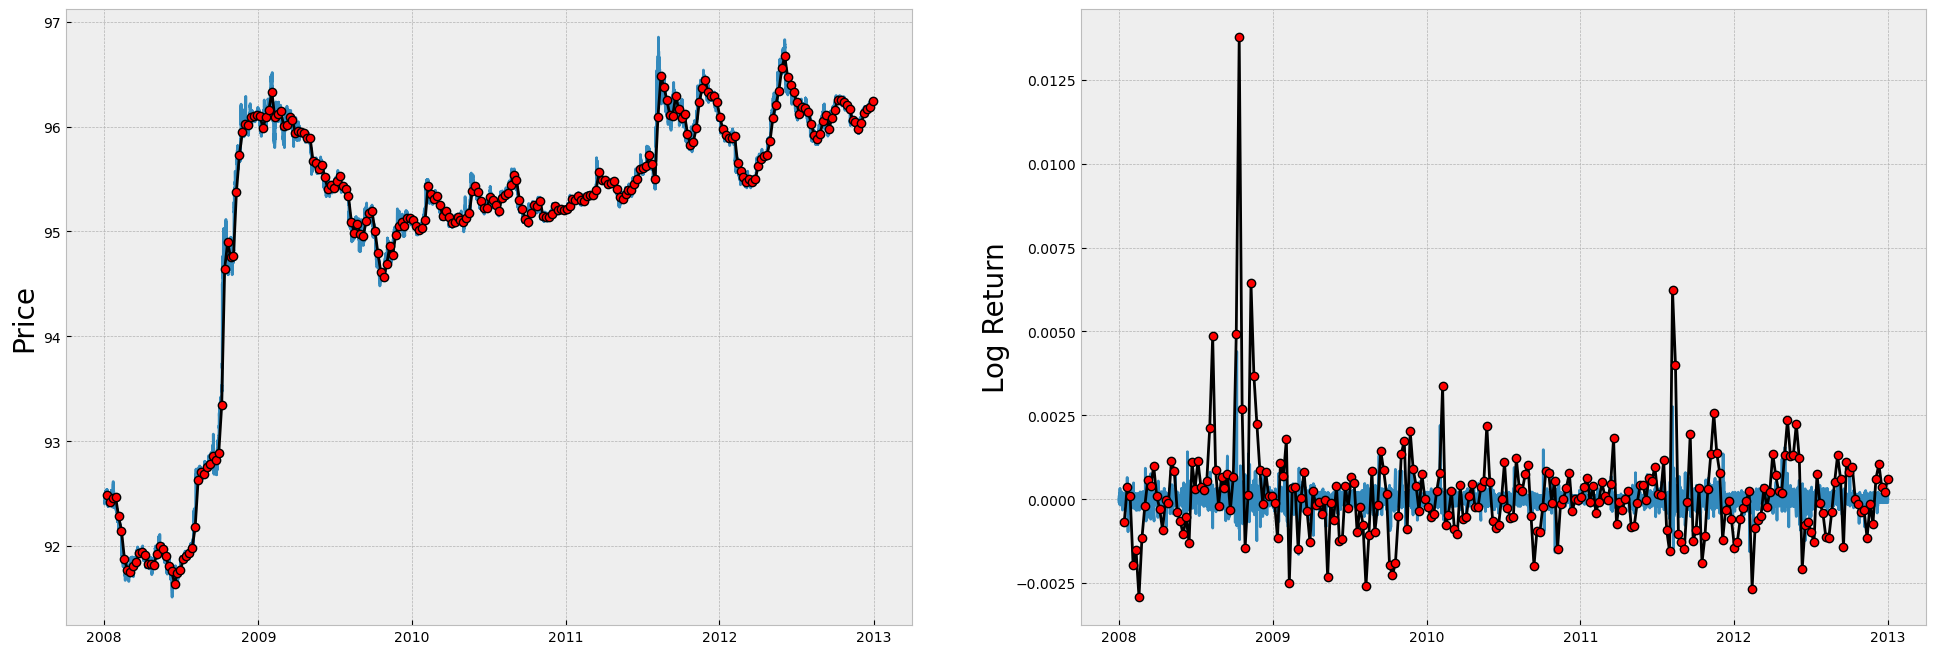

In [79]:
# Plot the first time series and its log return, using both the original cleaned data and the resampled data
fig, ax = plt.subplots(ncols=2, figsize=(24,8))
ax[0].plot(times_1, series_1)
ax[0].plot(weeks_1, weekly_series_1, color='black', lw=2, marker='o', markerfacecolor='red', zorder=34969) 
ax[0].set_ylabel('Price')

ax[1].plot(weeks_1[1:], log_weeks_1, color='black', lw=2, marker='o', markerfacecolor='red', zorder=34969)
ax[1].plot(times_1[1:], log_series_1)
ax[1].set_ylabel('Log Return');

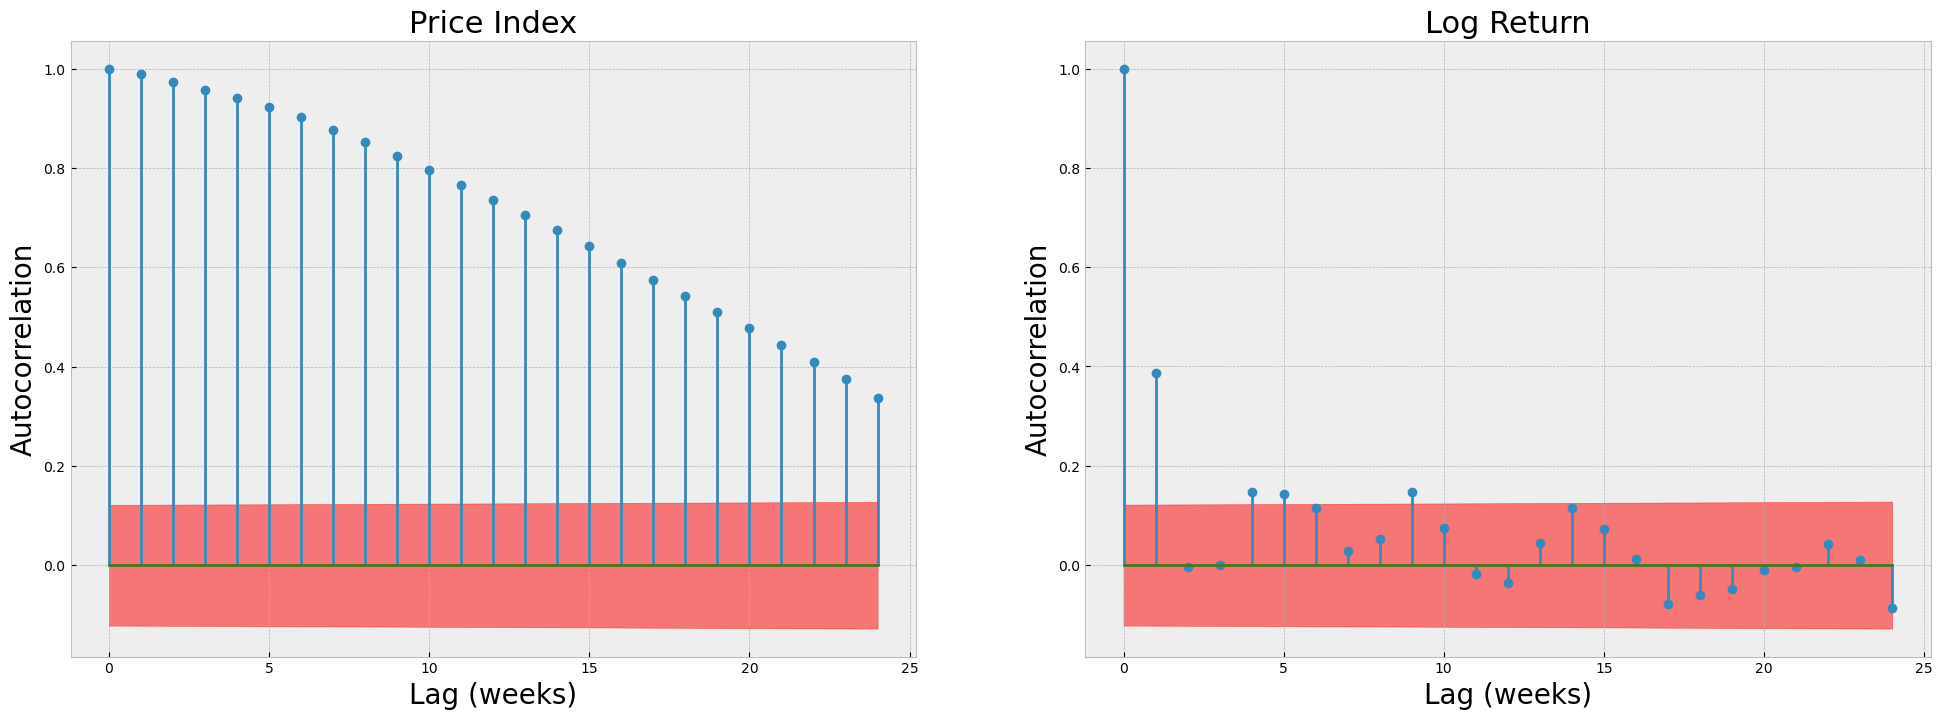

In [80]:
# Compute the autocorrelation of the price and the log return series using the resampled data
autocorr_1 = sm.tsa.acf(weekly_series_1, 26) # Check lag contributions up to about half a year.
log_autocorr_1 = sm.tsa.acf(log_weeks_1, 26)

# Define a function to return the statistically significant bounds for the autocorrelation analysis
def acf_bounds(series, autocorrelation):
    bound = 1.96/np.sqrt(len(series)-np.arange(1,len(autocorrelation)+1))
    return bound

bound_series_1 = acf_bounds(weekly_series_1, autocorr_1)
bound_log_1 = acf_bounds(log_weeks_1, log_autocorr_1)

# Plot the results
fig, ax = plt.subplots(ncols=2, figsize=(24,8))
ax[0].stem(range(len(autocorr_1)), autocorr_1)
ax[0].fill_between(range(len(autocorr_1)), -bound_series_1, bound_series_1,alpha=0.5, color='red')
ax[0].set_xlabel('Lag (weeks)')
ax[0].set_ylabel('Autocorrelation')
ax[0].set_title('Price Index', fontsize=22)


ax[1].stem(range(len(log_autocorr_1)), log_autocorr_1)
ax[1].fill_between(range(len(log_autocorr_1)), -bound_log_1, bound_log_1,alpha=0.5, color='red')
ax[1].set_xlabel('Lag (weeks)')
ax[1].set_ylabel('Autocorrelation')
ax[1].set_title('Log Return', fontsize=22);

We remark on our results: First, the autocorrelations of the resampled original price series are all statistically significant and slowly decay with respect to the number of lags, which is strong evidence for the non-stationarity of the time series. By contrast, the log return series has quickly decaying autocorrelations, with the most non-trivially occurring lags being 1 week, with lags 4, 5, and 9 being weakly statistically significant. 

We employ some additional testing by means of the Augmented Dickey-Fuller (ADF) test, determining whether there is a unit root in the series, and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, which tests whether the time series is trend-stationary by design. Note that although they share similar traits, unit root processes and trend-stationary processes are not the same. A differentiating trait is how they respond to "shocks" or random error, with trend-stationary processes being mean-reverting, in that they converge again towards the growing mean, whereas no convergence occurs for the unit-root process. As a consequence, we employ both tests to determine stationarity within the data.

As a reminder, the null and alternative hypotheses for the ADF test are:
- Null: A unit root is present in the time series sample.
- Alternative: A unit root is _not_ present in the time series sample.

Whilst for the KPSS test:
- Null: The time series is stationary around a deterministic trend (i.e. trend-stationary).
- Alternative: The time series has a unit root.

We compute these tests below for the log return of the 1st time series.

In [81]:
# Define a function to nicely print out the results of the ADF test
def adf_test(timeseries):
    print("Results of Augmented Dickey-Fuller Test:")
    # Note that the augmented Dickey-Fuller includes lags and the Akaike Information Criterion is used in order to choose the optimal lag for the test.
    dftest = sm.tsa.adfuller(timeseries, autolag="AIC") 
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [82]:
# Run the ADF test on the resampled log return
adf_test(log_weeks_1)

Results of Augmented Dickey-Fuller Test:
Test Statistic                -6.293159e+00
p-value                        3.558315e-08
#Lags Used                     3.000000e+00
Number of Observations Used    2.560000e+02
Critical Value (1%)           -3.456155e+00
Critical Value (5%)           -2.872897e+00
Critical Value (10%)          -2.572822e+00
dtype: float64


In [83]:
# Similarly define a function to nicely print out the results of the KPSS test
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    # Optimal lag is chosen according to a data-dependent method as detailed in 
    # Hobijn, B., Frances, B.H., & Ooms, M. (2004). "Generalizations of the KPSS-test for stationarity". Statistica Neerlandica, 52: 483-502.
    kpsstest = sm.tsa.kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [84]:
# Run the KPSS test on the log return series
kpss_test(log_weeks_1)

Results of KPSS Test:
Test Statistic           0.16193
p-value                  0.10000
Lags Used                4.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64


C:\Users\James\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


We comment on our results: The ADF test has produced a statistically significant result with p-value $3.6\times 10^{-8}$ indicating very strong evidence for rejecting the null hypothesis, such that there is **no unit root in the time series**.

On the other hand, the KPSS test has given a p-value greater than 0.1, strongly implying that the null hypothesis cannot be rejected and that the **time series is trend-stationary**.

Taken together, **these tests give strong evidence that the log return of time series 1 is stationary in the "weak" sense**.

With stationarity established, we further proceed with fitting an ARMA model to the data with the goal of generating forecasts. We need to exercise some caution as the optimal lags used in the ADF and KPSS tests were 3 weeks and 4 weeks respectively. Therefore, utilizing larger duration lags in the autoregression or the moving average may produce unusual results as our determination of stationarity is no longer valid.

As a preliminary attempt, we consider the simplest model with the dependence on the log return lagged by 1 week.

In [85]:
# Input the data into a Pandas dataframe, as many statistical fitting suites require it
data_to_fit = pd.Series(log_weeks_1,index=weeks_1[1:], name='Log Return 1')
data_to_fit = data_to_fit.asfreq('W-MON')

# Generate the end point of the data to ensure a 90-10 fitting-test split.
end_point = np.round(0.9*len(log_weeks_1)).astype(int)

# Print the dates associated with the fitting and testing data splits
print(f'Fitting dates: {data_to_fit.index[0]} - {data_to_fit.index[end_point]}')
print(f'Test dates: {data_to_fit.index[end_point+1]} - {data_to_fit.index[-1]}\n\n\n')

# Create an ARMA model (same as an ARIMA model with d = 0)
model = sm.tsa.arima.ARIMA(data_to_fit[:end_point], freq='W-MON', order=(1, 0, 1)) # First order autoregression, first order moving average

# Fit the model to the data
results = model.fit()

# Print the results
results.summary()

Fitting dates: 2008-01-14 00:00:00 - 2012-07-09 00:00:00
Test dates: 2012-07-16 00:00:00 - 2012-12-31 00:00:00





C:\Users\James\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Log Return 1   No. Observations:                  234
Model:                 ARIMA(1, 0, 1)   Log Likelihood                1200.891
Date:                Wed, 15 Mar 2023   AIC                          -2393.782
Time:                        18:59:44   BIC                          -2379.960
Sample:                    01-14-2008   HQIC                         -2388.209
                         - 07-02-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.912      0.362      -0.000       0.001
ar.L1         -0.0150      0.114     -0.131      0.895      -0.239       0.209
ma.L1          0.4922      0.118      4.184      0.000       0.262       0.723
sigma2      2.029e-06   8.39e-08     24.177      0.000    1.86e-06    2.19e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              4337.67
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                             2.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Mean-squared error is 2.0397150486209104e-06


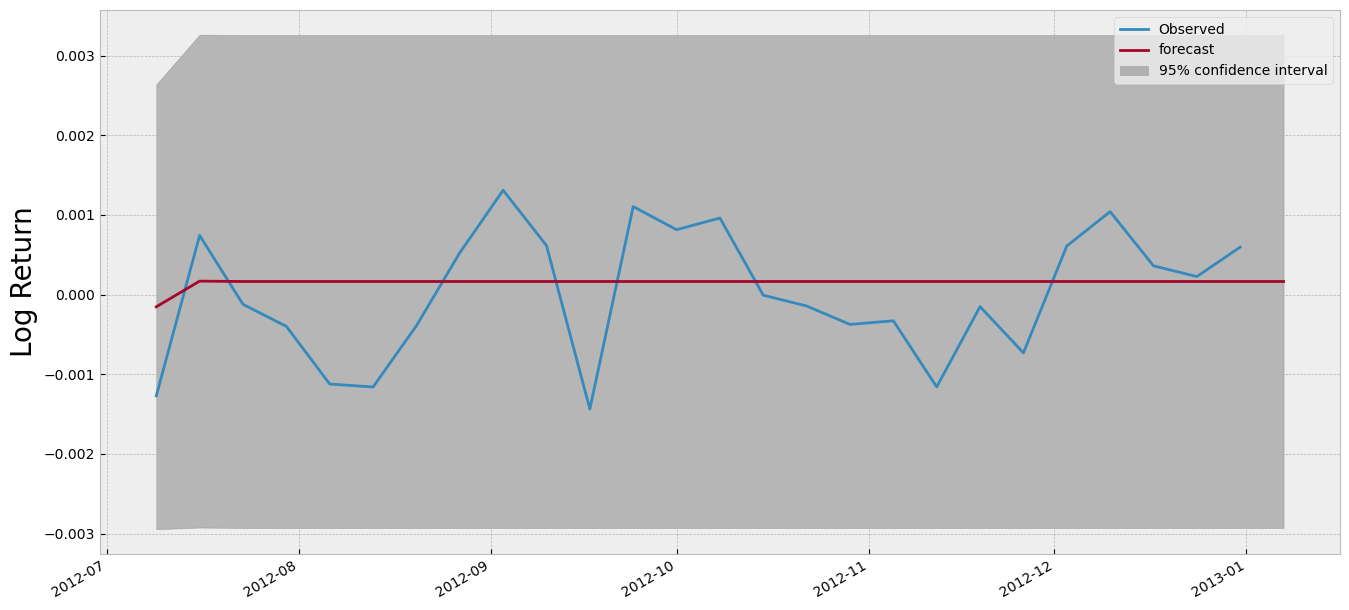

In [86]:
# Plot this along with the resampled log return
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(data_to_fit.index[end_point:], data_to_fit[end_point:],label='Observed')

# Generate predictions with the model
plot_predict(result=results, start=end_point, end=len(log_weeks_1), ax=ax)
plt.ylabel('Log Return')
plt.legend();

# Print the mean-squared error of the ARMA model
print(f'Mean-squared error is {results.mse}')

Naively, we might think the ARMA(1,1) is a "good" model, given that its mean-squared error is rather low at $10^{-6}$ and the log return oscillates to the order of $10^{-3}$. However, the model leaves a lot to be desired: Namely, the 95% confidence interval is too large to be of any use. 

Can we do better? Let's find out by trying a "Machine Learning" (really just statistical regression, without the buzzword) approach by means of the Scikit-Learn regressors.

In [87]:
# Organize the data into an 80-20 fitting-test split
new_split = np.round(0.8*len(data_to_fit)).astype(int) 
data_fitting = data_to_fit[:new_split]
data_test  = data_to_fit[new_split:]

print(f"Train dates : {data_fitting.index.min()} --- {data_fitting.index.max()}  (No. of points={len(data_fitting)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (No. of points={len(data_test)})")

Train dates : 2008-01-14 00:00:00 --- 2012-01-02 00:00:00  (No. of points=208)
Test dates  : 2012-01-09 00:00:00 --- 2012-12-31 00:00:00  (No. of points=52)


In [88]:
# Create and train a forecaster using the skforecast package
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=34969), lags = 5) # We do not want to use too many lags with the results of the autocorrelation analysis in mind.

# Fit the data
forecaster.fit(y=data_fitting)

In [89]:
# Define a function to generate predictions and compute the prediction interval before printing and plotting results
def generate_prediction(forecaster, data_test, confidence, n_boot):
    '''
    Input: forecaster - Fitted Forecaster class object from skforecast;
           data_test  - Pandas series of test to compare with model predictions;
           confidence - % confidence interval to generate;
           n_boot     - # of bootstrapped samples to use in generation of predictive interval;
    '''
    # Generate predictions using bootstrapping
    predictions = forecaster.predict_interval(
                    steps    = len(data_test),
                    interval = [(100-confidence)/2, confidence + (100-confidence)/2], # This computes the upper and lower bounds of the confidence interval...
                    n_boot   = n_boot         # ...using n_boot bootstrapped samples; the difference is that we do not require the realizations to be normally distributed, only that they are independent.
              )
    
    # Compute the mean squared error with the predictions
    error_mse = mean_squared_error(
                    y_true = data_test,
                    y_pred = predictions.iloc[:, 0]
                )

    print(f"Mean squared error is {error_mse}")
    
    # Use the conf_count function to compute % of observed points within confidence interval (see below)
    conf_count(data_test, predictions)

    # Plot the resampled log return series, the prediction, and the
    fig, ax = plt.subplots(figsize=(16, 8))
    data_test.plot(ax=ax, label='Observed')
    predictions['pred'].plot(ax=ax, label='Forecast')
    ax.fill_between(
        predictions.index,
        predictions['lower_bound'],
        predictions['upper_bound'],
        color = 'grey',
        alpha = 0.5,
        label = f'{confidence} Confidence Interval'
    )
    ax.legend();
    
    return predictions

# Define a function to compute the % of observed points within the confidence interval
def conf_count(data_test, predictions):
    # Initialize a counter
    count = 0
    # Begin looping through each point in the test data
    for i in range(len(data_test)):
        # If the observed point is higher than the upper bound of the confidence interval...
        if data_test[i] > predictions['upper_bound'][i]:
            count += 1
        # If the observed point is lower than the lower bound of the confidence interval...
        elif data_test[i] < predictions['lower_bound'][i]:
            count += 1
        else:
            continue
    # Print the results
    print(f'{100*(len(data_test)-count)/(len(data_test))}% of observed points within the confidence interval\n')
    return

Mean squared error is 1.0487383885095256e-06
84.61538461538461% of observed points within the confidence interval



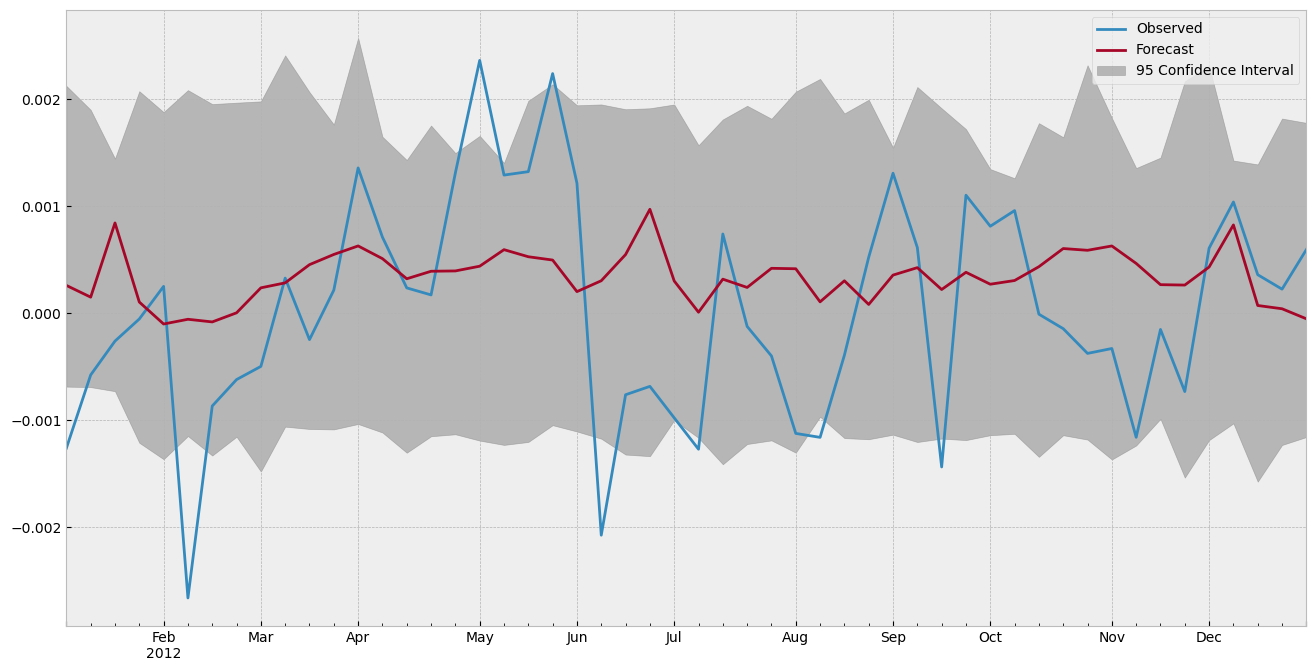

In [90]:
# Generate predictions using the fitted model and error metrics
predictions = generate_prediction(forecaster, data_test, 95, 500)

We remark on our results: First, by using a more sophisticated model in the form of a random forest ensemble, we have obtained a reduced mean square error of about 40% when compared to the original ARMA(1,1) model. Furthermore, the 95% confidence interval exhibits more restrictive upper and lower bounds, though it is a little too restrictive given that only 84.6% of the observed points were within the interval out of a total of 52 points.

We can squeeze a little more performance out of the random forest model by means of hyperparameter tuning; namely, running a grid search of various hyperparameters of the model and returning the "best" model which reduces the mean square error when compared to the test data.

In [91]:
# Set up the hyperparameter grid search
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=34969),
                lags      = 5 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [5, 9] # Use the lags found to be statistically significant from autocorrelation analysis

# Consider the hyperparameters of the random forest regressor
param_grid = {'n_estimators': [50, 75, 100, 200, 500], 'max_depth': [3, 5, 10, 15, 20]}

# Employ backtesting on unseen training data to tune the hyperparameters and minimize the mean squared error
results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_fitting,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = len(data_fitting),
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_fitting)-1),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 50.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:12<00:00,  6.28s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 15, 'n_estimators': 100}
  Backtesting metric: 7.379005011247916e-07



Mean squared error is 1.0686102565514601e-06
84.61538461538461% of observed points within the confidence interval



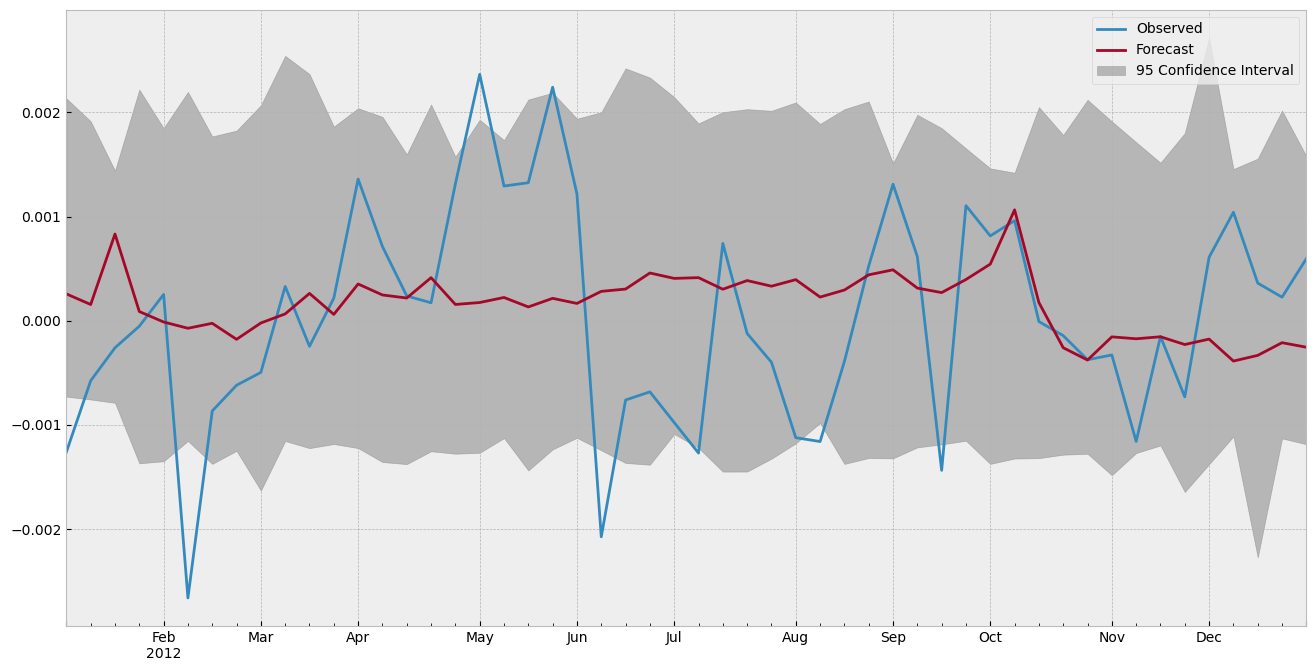

In [92]:
# Create a new model with the tuned hyperparameters
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=34969, max_depth=15, n_estimators=100), lags = 5)

# Fit the data
forecaster.fit(y=data_fitting)

# Again, generate predictions using the best model
predictions = generate_prediction(forecaster, data_test, 95, 500)

We conclude our analysis of time series 1 by commenting that our hyperparameter tuning has produced a model which has a slightly higher mean square error when compared to the first naive model. This result suggests that we have likely hit a ceiling in regards to the predictive performance exhibited by the random forest models. From here, one could investigate the viability of other regressions or one could go back to the original data and manipulate it so that it has a finer but equally spaced time resolution to provide more fitting data.

As with any statistical model, we compute the importance of its features; namely how dependent the predictions were on the lags of the log return.

In [93]:
# Print the feature importance
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.494071
1,lag_2,0.096194
2,lag_3,0.110299
3,lag_4,0.175083
4,lag_5,0.124353


Curiously, the high dependence on the first lag mirrors our previous results from autocorrelation analysis, as well as the marginal dependence on the fourth and fifth lags. However, in contrast, the fitted model exhibits greater dependence on the second and third lags which the autocorrelation analysis determined was not statistically significant at the 95% level.

## Can time series 2 be used to predict its own future?

Having employed more traditional econometrics in the previous section, we now opt for a spectral-analysis approach via discrete wavelets to determine whether any extra insight can be obtained from the data. Wavelet analysis has some significant advantages over standard Fourier analysis in that it breaks down the total signal into both a frequency and a spatial components, as opposed to Fourier analysis which only gives the frequency space of the signal with the underlying assumption that the signal infinitely repeats.

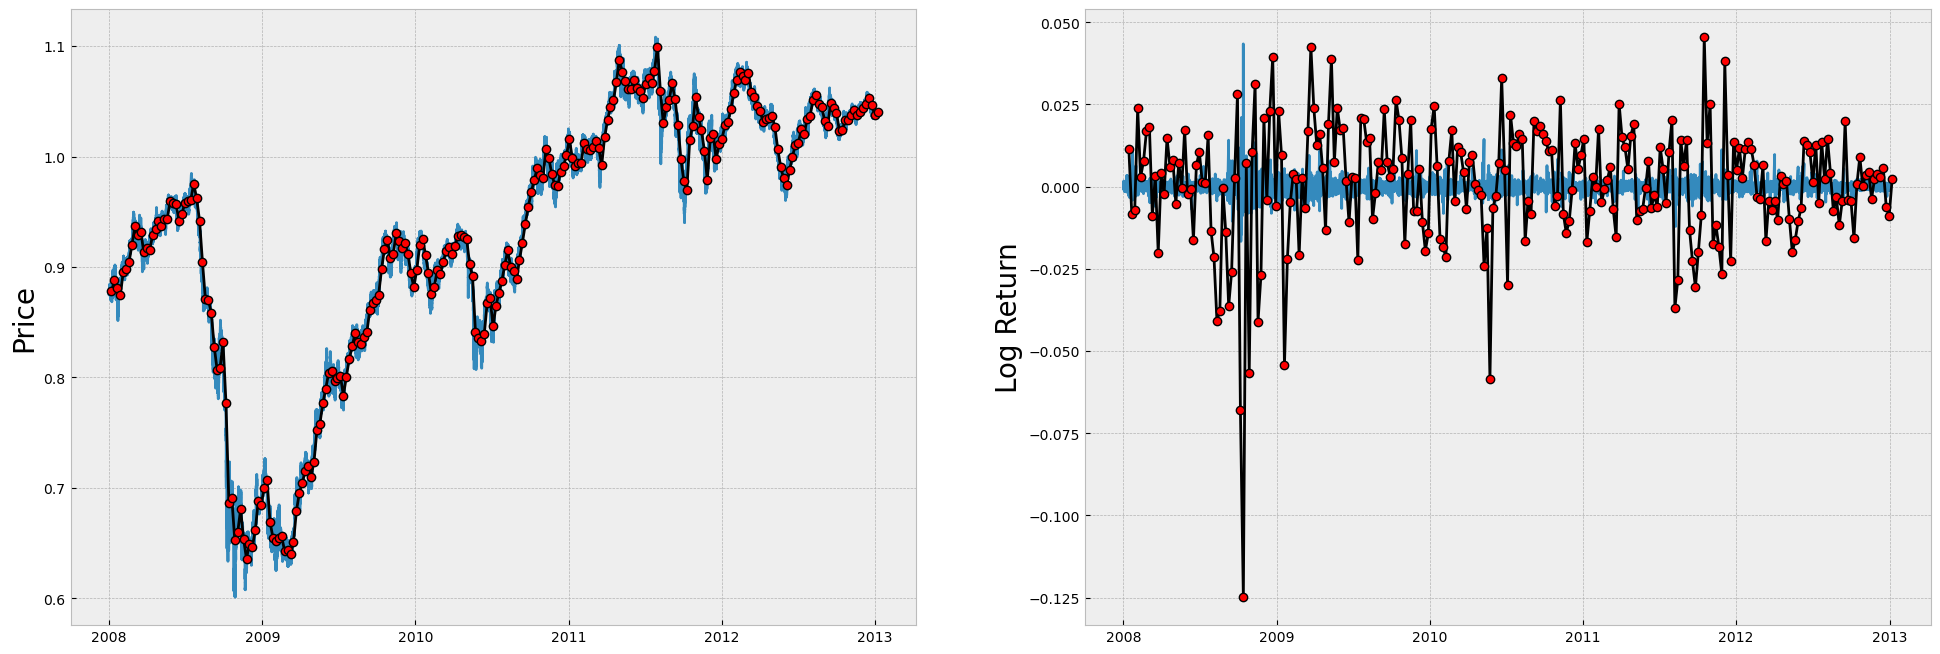

In [94]:
# Plot the second time series and its log return, using both the original cleaned data and the resampled data
fig, ax = plt.subplots(ncols=2, figsize=(24,8))
ax[0].plot(times_2, series_2)
ax[0].plot(weeks_2, weekly_series_2, color='black', lw=2, marker='o', markerfacecolor='red', zorder=34969) 
ax[0].set_ylabel('Price')

ax[1].plot(weeks_2[1:], log_weeks_2, color='black', lw=2, marker='o', markerfacecolor='red', zorder=34969)
ax[1].plot(times_2[1:], log_series_2)
ax[1].set_ylabel('Log Return');

In [95]:
# Compute the complete discrete wavelet decomposition of the log return
decomp = pywt.wavedec(log_weeks_1, 'db2')

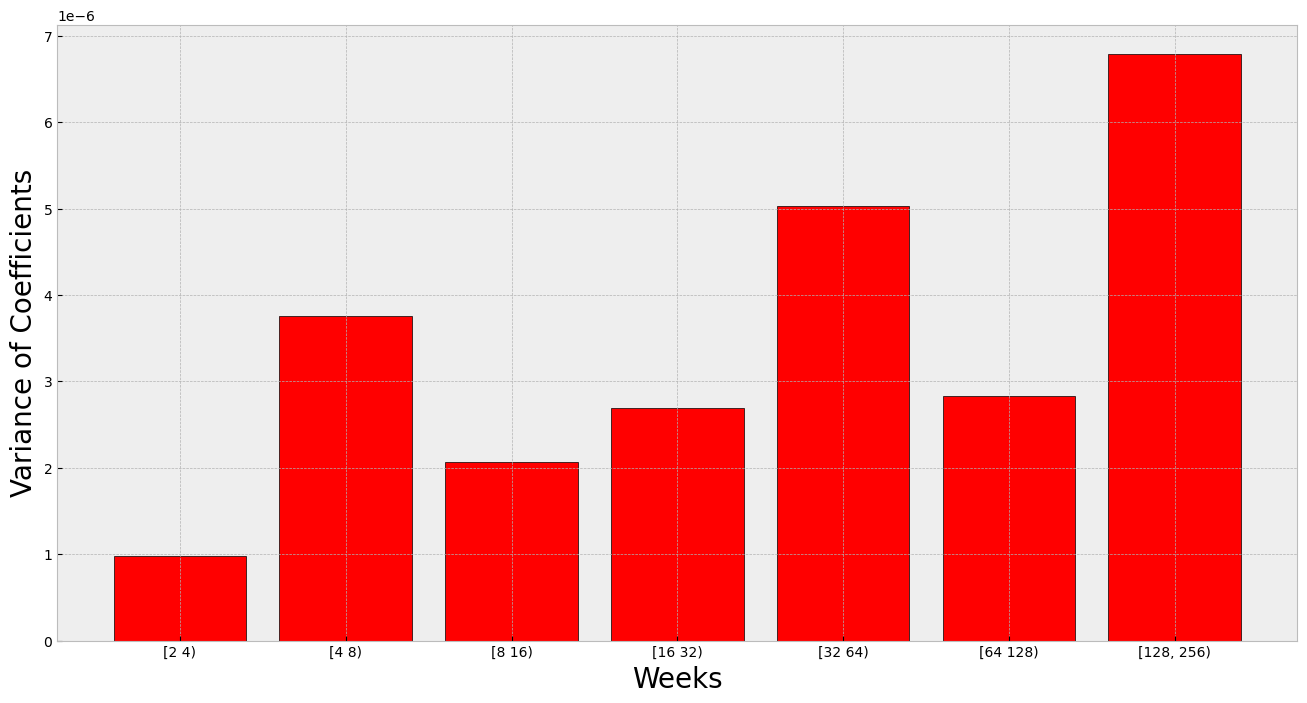

In [96]:
# Compute the variance of each of the coefficient bands
decomp_variance = []
for i in range(len(decomp)):
    decomp_variance.append(np.var(decomp[i]))
# Reverse the list so that the high frequency components are first
decomp_variance.reverse()
# Plot the results as a bar plot
plt.bar(range(len(decomp)),decomp_variance, color='red', edgecolor='black')
plt.xticks(np.arange(len(decomp)),['[2 4)','[4 8)','[8 16)','[16 32)','[32 64)','[64 128)', '[128, 256)'])
plt.xlabel('Weeks')
plt.ylabel('Variance of Coefficients');

We discuss the figure above: In computing the complete wavelet decomposition using the Daubechies 2 wavelet 'db2', the total log return was decomposed into different frequency scales, with the highest frequency scale corresponding to oscillations in 2-4 weeks and the lowest frequency scale corresponding to 128-256 weeks, given that our data was resampled into weeks. 

For each scale, we computed the variance of the wavelet coefficients, in essence how "similar" the signal is to the wavelet at a particular time and frequency scale, to determine which frequency scale dominates the variance seen in the log return.

From above, the biggest contributor is the lowest frequency scale ranging between 128-256 weeks, followed by 32-64 weeks, and 4-8 weeks, each comprising a total of 28%, 21%, and 16% of the total variance of the log return.

We plot these three additive resolution scales below.

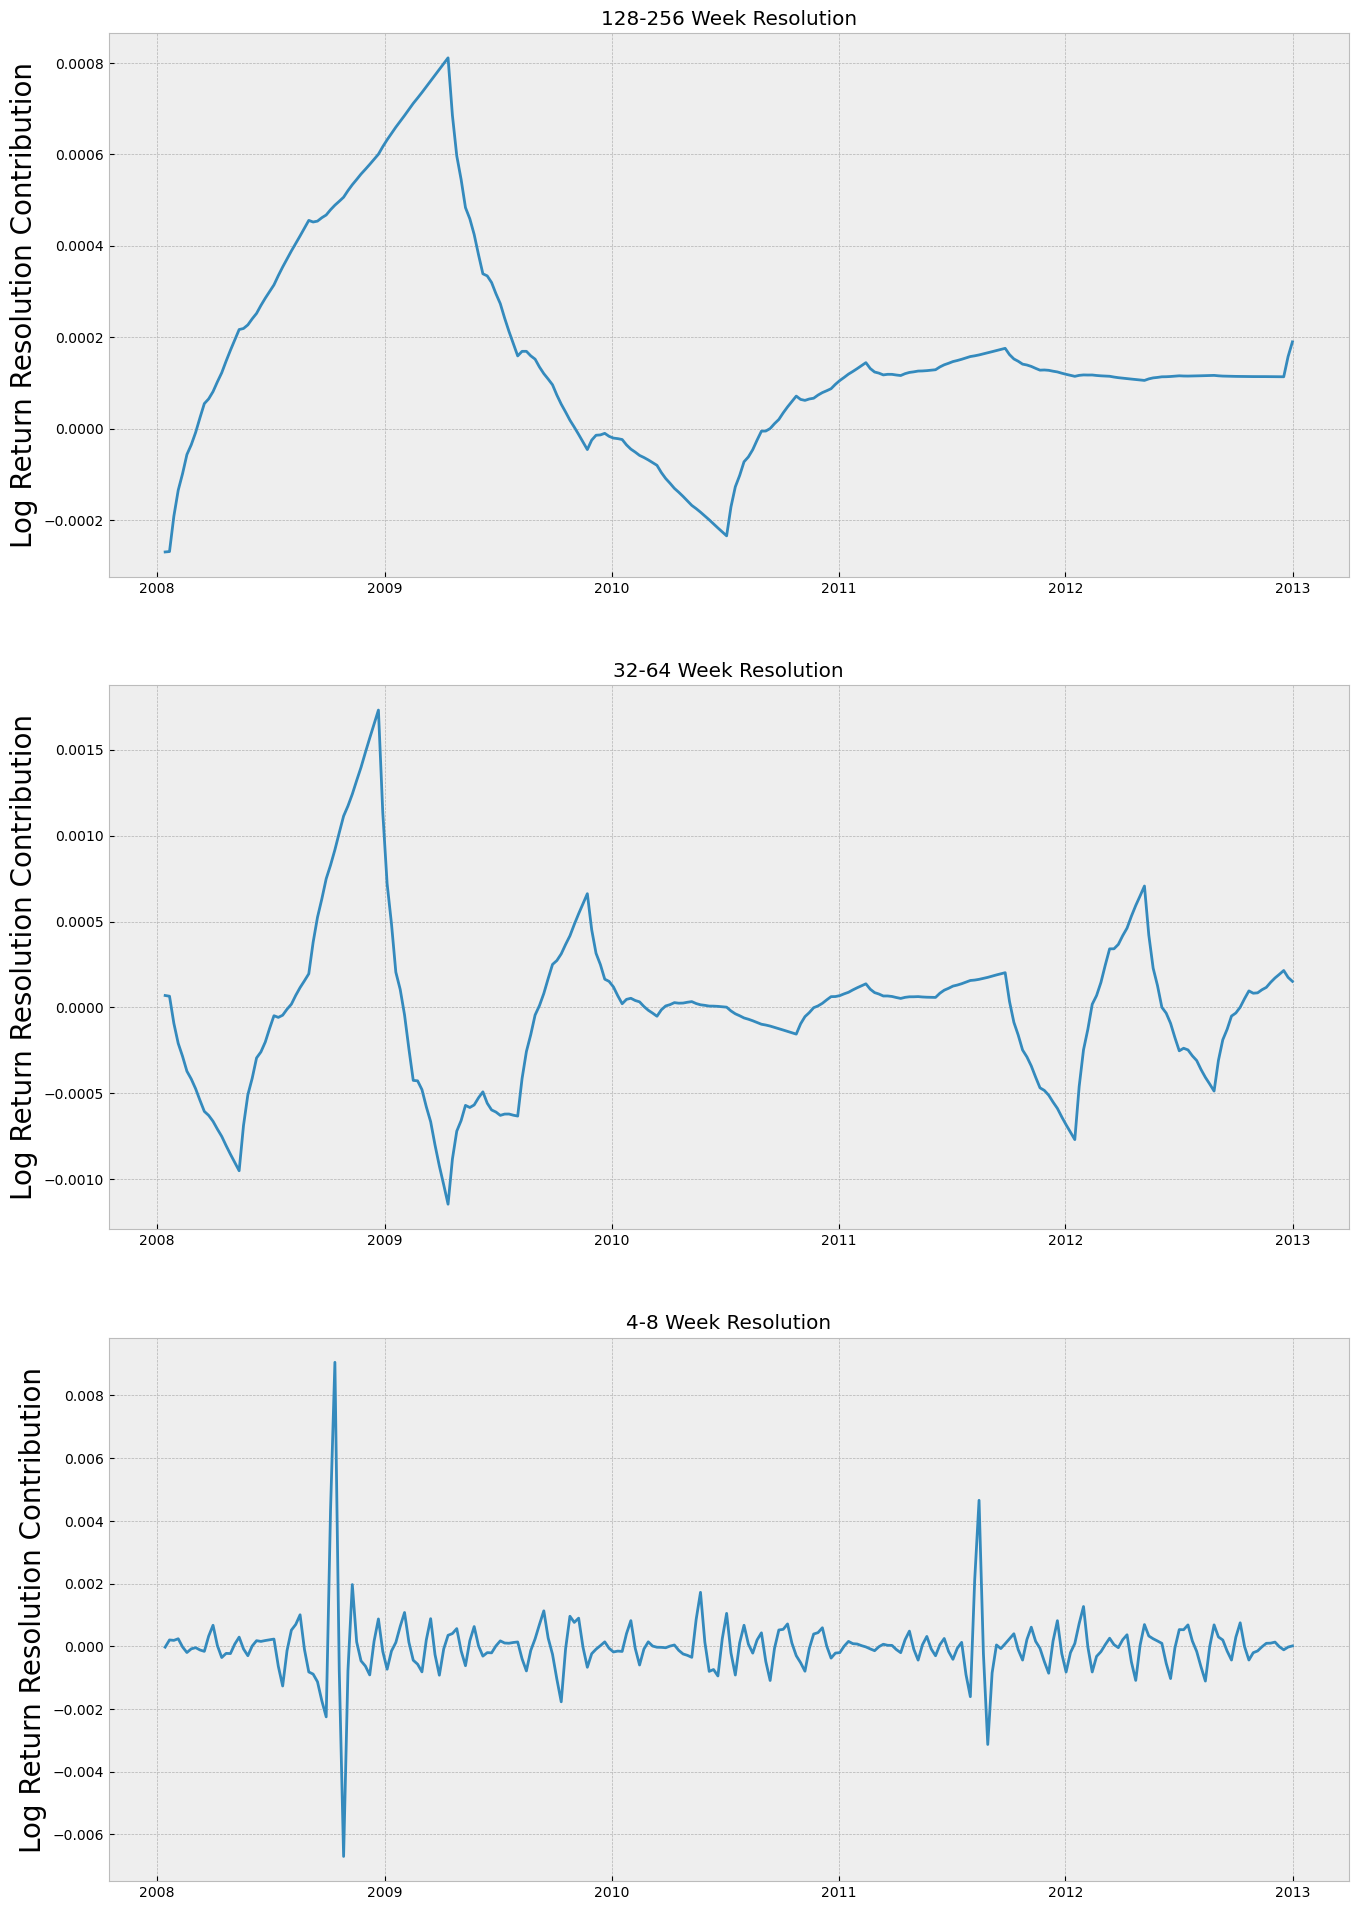

In [97]:
fig, ax = plt.subplots(nrows=3, figsize=(16,24))
# Plot the 128-256 week scale
ax[0].plot(weeks_1[1:],pywt.mra(log_weeks_1, 'db2', transform='dwt', mode='symmetric')[0])
ax[0].set_title('128-256 Week Resolution')
ax[0].set_ylabel('Log Return Resolution Contribution')
# Plot the 32-64 week scale
ax[1].plot(weeks_1[1:],pywt.mra(log_weeks_1, 'db2', transform='dwt', mode='symmetric')[2])
ax[1].set_title('32-64 Week Resolution')
ax[1].set_ylabel('Log Return Resolution Contribution')
# Plot the 4-8 week scale
ax[2].plot(weeks_1[1:],pywt.mra(log_weeks_1, 'db2', transform='dwt', mode='symmetric')[-2])
ax[2].set_title('4-8 Week Resolution')
ax[2].set_ylabel('Log Return Resolution Contribution');

It cannot be understated how much information we can gleam from wavelet analysis, whether it be the two large localized and high frequency shocks in the 4-8 week resolution, corresponding to the large jumps in the log return in the original series, or the low frequency trend that, over the period of 2008-2013, exhibits a net increase.

A nice property of the discrete wavelet decomposition is that one can zero coefficients within the various resolution bands to denoise a signal, without discontinuities introduced when the signal is reconstructed, in stark contrast to the continuous wavelet transform.

To this end, we only retain the coefficients in the 128-256, 32-64, and 4-8 week bands and zero everything before reconstructing the original log return. 

In [98]:
# Define a function to denoise a signal by zeroing all coefficients of all but the retained resolution bands
def wavelet_denoise(decomp, retained_indices):
    '''
    Input: decomp - NumPy array which is the output of pywt.wavedec
           retained_indices - List or NumPy array of resolution band indices to retain
    '''
    
    # Initialize the new decomposition which will store the zeroed coefficients
    clean_decomp = []
    for i in range(len(decomp)):
        # If the resolution band is the one we want to keep...
        if i in retained_indices:
            # Simply store it without doing anything
            clean_decomp.append(decomp[i])
        else:
            # Store an array of zeroed coefficients
            clean_decomp.append(np.zeros(len(decomp[i])))
            
    # Return the denoised wavelet decomposition
    return clean_decomp

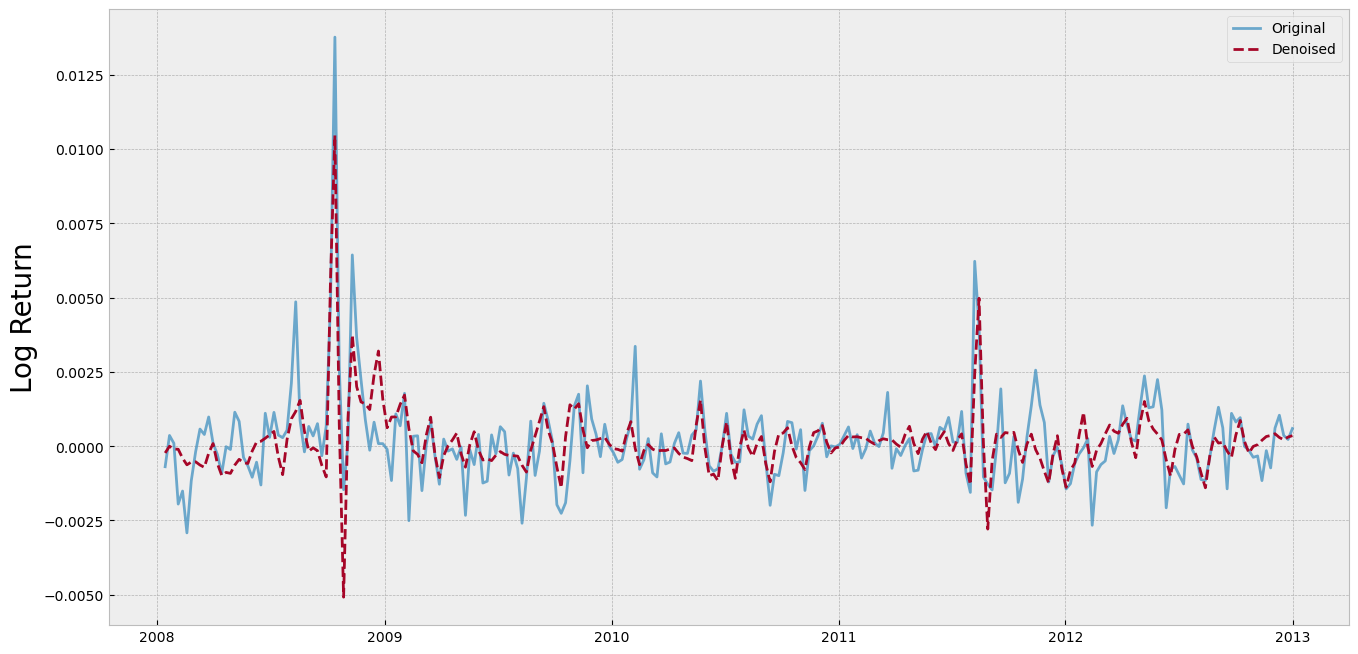

In [99]:
# Denoise the log return series retaining the largest contributors to the variation of the signal
clean_decomp = wavelet_denoise(decomp, [0, 2, 5])

# Reconstruct the cleaned decomposition and plot it with the original log return
new_return = pywt.waverec(clean_decomp, 'db2')
plt.plot(weeks_1[1:], log_weeks_1, label='Original', alpha=0.7)
plt.plot(weeks_1[1:], new_return, ls='dashed', label='Denoised')
plt.ylabel('Log Return')
plt.legend();

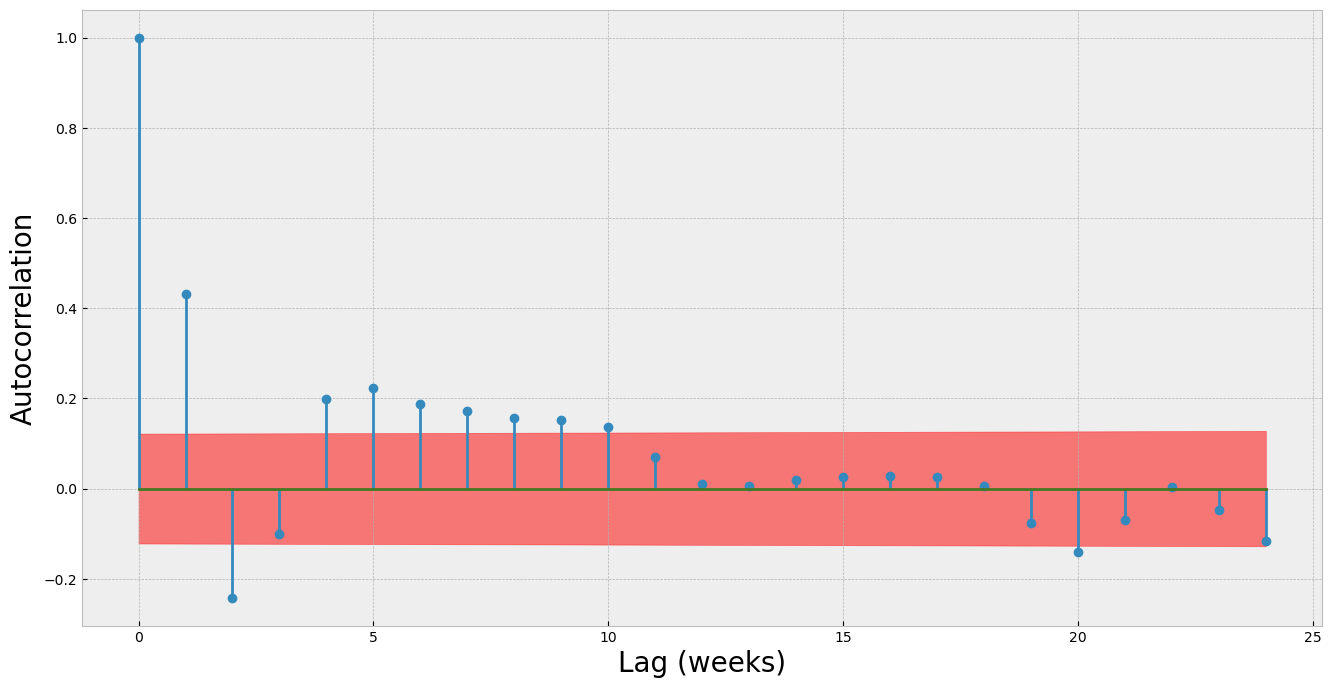

In [100]:
# Compute the autocorrelation of the price and the log return series using the resampled data
log_autocorr_2 = sm.tsa.acf(new_return, 24)

# Compute the ACF statistical significance bounds
bounds_2 =acf_bounds(new_return, log_autocorr_2)

# Plot the results
plt.stem(range(len(log_autocorr_2)), log_autocorr_2)
plt.fill_between(range(len(log_autocorr_2)), -bounds_2, bounds_2, alpha=0.5, color='red')
plt.xlabel('Lag (weeks)')
plt.ylabel('Autocorrelation');

We conclude this section with some comments: Whilst we ultimately computed the autocorrelation at the end similar to the first section, even finding a similar short-term lag dependency, the exploration into wavelet analysis highlighted some neat ways where it could be used to denoise or highlight certain aspects of the time series, such as its volatility and how it evolves over time. 

# Can one time series be used to predict the other time series?

We double check whether the second time series is stationary. If so, we can then test for cointegration between both time series. Note that cointegration is not the same as cross-correlation, as the latter tests whether the two time series are lags of each other, whereas cointegration tests whether the two series will vary around a shared mean. While the cointegrated series may not follow the same path, as demanded in cross-correlation, they will both end up at the same destination, which is important if want to develop a pair-trading strategy.

In [101]:
# Determine whether time series 2 is stationary by first running the ADF and KPSS tests as previously
adf_test(log_weeks_2)
print('\n') # New line
kpss_test(log_weeks_2)

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -5.131455
p-value                          0.000012
#Lags Used                       5.000000
Number of Observations Used    255.000000
Critical Value (1%)             -3.456257
Critical Value (5%)             -2.872942
Critical Value (10%)            -2.572846
dtype: float64


Results of KPSS Test:
Test Statistic           0.106963
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\James\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


As with time series 1, we have strong evidence that time series 2 is also a stationary process. We therefore proceed with testing for co-integration according to the augmented Engle-Granger test. As a reminder, the hypotheses of the test is:
- Null: There is no cointegration between the two time series.
- Alternative: There is cointegration between the two time series.

In [102]:
# Run the cointegration test
# Note that the shift in the number of data points is due to the respective time series not quite starting and finishing on the same date.
# For most accurate comparison, the cointegration test must be done on the same dates!
coint_score, coint_p, _ = sm.tsa.coint(pd.Series(log_weeks_1[1:], index=weeks_1[2:]), pd.Series(log_weeks_2[1:-1], index=weeks_2[2:-1]))

print(f'p-value for augmented Engle-Granger test is {coint_p}')

p-value for augmented Engle-Granger test is 6.106111029589422e-07


The above p-value provides convincing evidence that the null hypothesis be rejected, therefore implying that the two log returns are cointegrating. Therefore, we plot the difference between the two series and the corresponding mean of the new series. However, we scale this with the mean and normalize with respect to the standard deviation of the differences to produce the associated Z-scores.

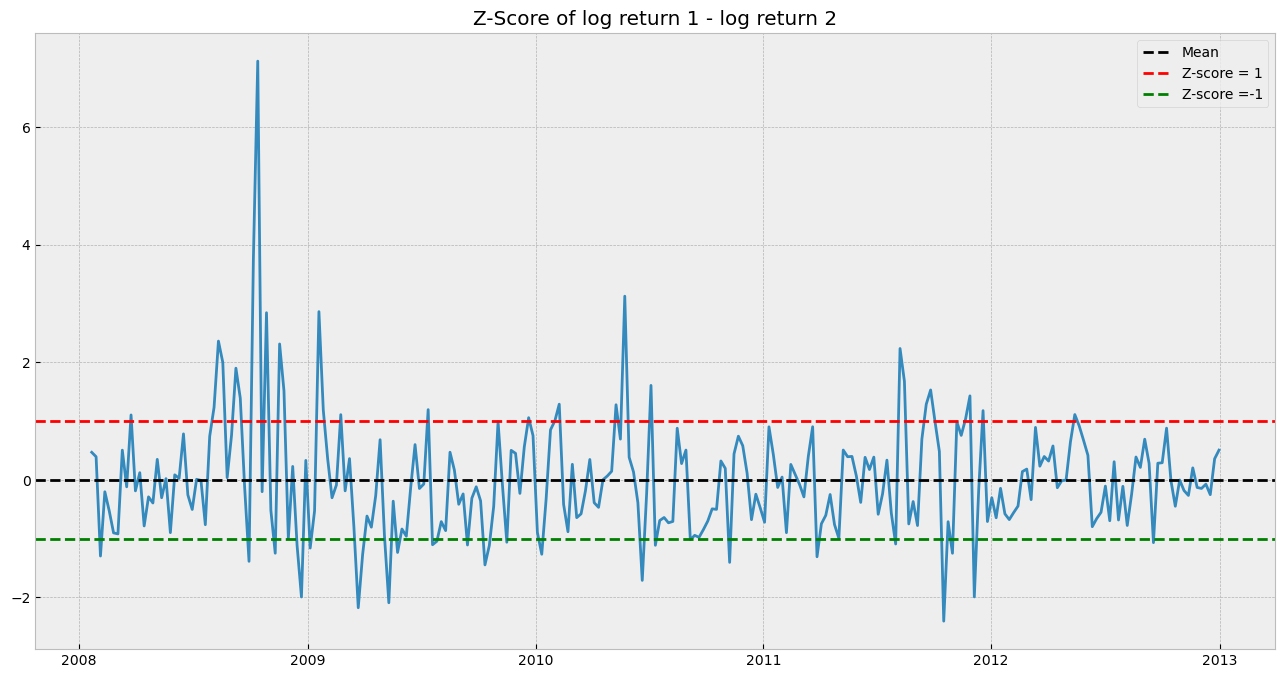

In [103]:
difference = log_weeks_1[1:]-log_weeks_2[1:-1]
plt.plot(weeks_1[2:],(difference-np.mean(difference))/np.std(difference))
plt.axhline(np.mean(difference), ls='dashed', label='Mean', color='black')
plt.axhline(1, color='red', ls='dashed', label='Z-score = 1')
plt.axhline(-1, color='green', ls='dashed', label='Z-score =-1')
plt.title('Z-Score of log return 1 - log return 2')
plt.legend();

The above graphic allows us to develop a very simplistic trading strategy for the two time series, namely along the lines of whether the Z-score of the difference between log return 1 and 2 is greater than 1 or less than -1. 
- If the Z-score is less than -1, go "long" by buying shares in time series 1 and sell short shares in time series 2.
- If the Z-score is greater than 1, go "short" by buying shares in time series 2 and sell short shares in time series 1.
- Exit the investment position when Z-score approaches 0.

There are numerous other considerations which should be further researched, namely, whether there is some optimal weighting for the amount invested into time series 1 or time series 2, (i.e. shares, if these are stock prices). Additionally, various denoising strategies can be used to further smooth the data and yield an underlying low frequency trend to determine whether entering an investment is a good choice at a particular time.